# 09_R : 텍스트 분석

In [2]:
# 예측 분석 모델링 실무 기법
# 소스(원저자) - http://www.ftpress.com/promotions/modeling-techniques-in-predictive-analytics-139480
# 소스(역자) - http://blog.naver.com/skk1991/220238139920
# 변경된 코드 - https://books.google.co.kr/books?id=PU6nBAAAQBAJ&pg=PT145&lpg=PT145

In [3]:
# Text Analysis of Movie Tag Lines

options(warn=-1)

In [5]:
library(tm)  # text mining and document management
library(proxy) # dissimilarity calculations by dist()
library(stringr)  # character manipulation with regular expressions
library(grid)  # grid graphics utilities
library(ggplot2)  # graphics
library(latticeExtra)  # package used for text horizon plot
library(wordcloud)  # provides utility for plotting non-overlapping text
library(cluster)  # cluster analysis

In [6]:
# R 기본 콘솔이나 RStudio 환경에서는 이렇게 하면 그래프 함수를 쓸 수 있다.
# 하지만 현재 쥬피터 환경에서는 안된다. 
# 그러므로 이 쥬피터의 맨 밑 셀에 있는 그래프 함수를 실행해서
# 전역 메모리에 함수를 얹어놓고
# 그 뒤에 코드를 실행해나가면 된다.
load("09_data/text/mtpa_split_plotting_utilities.Rdata")

In [7]:
# standardization needed for text measures
standardize <- function(x) {(x - mean(x)) / sd(x)}

In [8]:
# convert to bytecodes to avoid "invalid multibyte string" messages
bytecode.convert <- function(x) {iconv(enc2utf8(x), sub = "byte")}

In [9]:
# NLINES <- 21  # for development and test runs
# input.data.file.name <- "taglines_list_sample.txt"
#  scan("taglines_list_sample.txt", what = "character")  # development runs
# nlines_to_read <- 21  # for development and test runs

# there are 345317 records in the full taglines data file
# the number of lines in the input data file
# or maximum number of lines to read
NLINES <- 345317   
input.data.file.name <- "09_data/text/taglines_copy_data.txt"  # production runs
# read the data in blocks of nlines_to_read at a time
nlines_to_read <- 10000  # size of block of lines to read

In [10]:
# debug print was used during the code development process
debub.print.mode <- FALSE
debug.print <- function(title,date,tagline,status) {
  cat("\n title =",title,"  date = ", date," tagline",
    tagline, " status = ",status,"\n")
  }

In [11]:
# this user-defined function shows how R can be used to parse text input
tagline.parser <- function(input.list) {
# where we start depends upon the status on entry
# tagline parser can only be in one status at a time
# begin
# indicator
# title (actually a title and date status)
# moretitle (another title and data status, but following a previous title)
# tagline
# comment

# data are not clean... if you get a new movie indicator "#" start a new movie
# we may lose a few movies this way... but that is better than editing a file
# with about 40 thousand movies..

# at this time all valid dates should look be six characters long
# four numbers surrounded by parentheses 
# lets use The Birth of a Nation (1915) as the earliest possible valid date
# and the current year as the latest possible valid date 
# obtained by as.numeric(format(Sys.time(), "%Y"))
valid.years <- 1915:as.numeric(format(Sys.time(), "%Y"))
valid.years.strings.four <- paste("(",as.character(valid.years),sep="")

   text <- input.list[[1]]
   status <- input.list[[2]]
   title <- input.list[[3]]
   date <- input.list[[4]]
   tagline <- input.list[[5]]
   
   nitems <- length(text)
   ncount <- 1  # initialize on entry
   tagline_data.store <- NULL
   
   while(ncount < nitems) {   
# debug printing was used in the development and testing of parsing logic   
     if (debub.print.mode) debug.print(title,date,tagline,status) 
     if (status == "indicator" | status == "begin") {
       if (ncount <= nitems) {
         ncount <- ncount + 1
         status <- "initialtitle"
         title <- " "  # blank title to start
         date <- " "   # blank date to start
         tagline <- " "  # blank tagline to start
         }
       }
       
     if (status == "initialtitle") {
       if (ncount <= nitems) {
         title <- text[ncount]
         ncount <- ncount + 1
         if (ncount <= nitems) {
           test_date <- text[ncount]
           if (substring(test_date,1,5) %in% valid.years.strings.four) {
             date <- test_date
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (!(substring(test_date,1,5) %in% valid.years.strings.four)) {     
             if (test_date == "#") {
                 status <- "indicator"
                 }           
             if (test_date != "#") {
                 title <- paste(title, test_date)  
                 ncount <- ncount + 1 
                 status <- "moretitle"
                 }               
             } 
           }  
         }
       }
                                        
     if (status == "moretitle") {
       if (ncount <= nitems) {
         ncount <- ncount + 1
         if (ncount <= nitems) {
           test_date <- text[ncount]
           if (substring(test_date,1,5) %in% valid.years.strings.four) {
             date <- test_date
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (!(substring(test_date,1,5) %in% valid.years.strings.four)) {     
             if (test_date == "#") {
                 status <- "indicator"
                 }           
             if (test_date != "#") {
                 title <- paste(title, test_date)  
                 ncount <- ncount + 1  
                 }               
             } 
           }  
         }
       }                    
                                       
       if (status == "tagline") {
         if (ncount <= nitems) {
           new_text <- text[ncount]
           if (new_text == "#") {
             tagline_data.store <- rbind(tagline_data.store,
                data.frame(title, date, tagline, stringsAsFactors = FALSE))
                status <- "indicator"
             }           
           if (new_text != "#") {
             if (substring(new_text,1,1) == "{") {
               ncount <- ncount + 1
               status <- "comment"
               }
             if (substring(new_text,1,1) != "{") {
               tagline <- paste(tagline, new_text)
               ncount <- ncount + 1
               }
             }             
           }          
         }
  
       if (status == "comment") {
         if (ncount <= nitems) {
           new_text <- text[ncount]         
           if (substring(new_text,nchar(new_text),nchar(new_text)) == "}") {
             ncount <- ncount + 1
             status <- "tagline"
             }
           if (substring(new_text,nchar(new_text),nchar(new_text)) != "}") {
             ncount <- ncount + 1
             }
           }
         }  
  } # end of primary while-loop
list(tagline_data.store, status, title, date, tagline)  # return list
}  # end of function

In [12]:
cat("\n\n","NUMBER OF LINES READ: ")



 NUMBER OF LINES READ: 

In [13]:
skip <- 0  # initialize the number of lines to skip
nlines_read_so_far <- 0  # intitialze number of lines read so far

In [14]:
status <- "begin"  # initial status
title <- " "  # blank title to start
date <- " "   # blank date to start
tagline <- " "  # blank tagline to start

In [15]:
data.store <- NULL  # initialize the data frame for storing text data

In [16]:
while(nlines_read_so_far < NLINES)  {

if ((NLINES - nlines_read_so_far) < nlines_to_read) 
  nlines_to_read <- (NLINES - nlines_read_so_far)
  
text <- scan(file = input.data.file.name, what = "character",
    skip = nlines_read_so_far, nlines = nlines_to_read)
 
# convert individual text items to bytecodes 
# to avoid to avoid "invalid multibyte string" error messages going forward
text <- bytecode.convert(text)

input.list <- list(text, status, title, date, tagline)  
 
# parse this block of text with the tagline parser function 
output.list <- tagline.parser(input.list) 
  
  new_data_for_store <- output.list[[1]]
  status <- output.list[[2]]
  title <- output.list[[3]]
  date <- output.list[[4]]
  tagline <- output.list[[5]]
      
  data.store <- rbind(data.store, new_data_for_store)
  
  nlines_read_so_far <- nlines_read_so_far + nlines_to_read
  
  cat(" ","nlines_read_so_far:",nlines_read_so_far)
  }

  nlines_read_so_far: 10000  nlines_read_so_far: 20000  nlines_read_so_far: 30000  nlines_read_so_far: 40000  nlines_read_so_far: 50000  nlines_read_so_far: 60000  nlines_read_so_far: 70000  nlines_read_so_far: 80000  nlines_read_so_far: 90000  nlines_read_so_far: 1e+05  nlines_read_so_far: 110000  nlines_read_so_far: 120000  nlines_read_so_far: 130000  nlines_read_so_far: 140000  nlines_read_so_far: 150000  nlines_read_so_far: 160000  nlines_read_so_far: 170000  nlines_read_so_far: 180000  nlines_read_so_far: 190000  nlines_read_so_far: 2e+05  nlines_read_so_far: 210000  nlines_read_so_far: 220000  nlines_read_so_far: 230000  nlines_read_so_far: 240000  nlines_read_so_far: 250000  nlines_read_so_far: 260000  nlines_read_so_far: 270000  nlines_read_so_far: 280000  nlines_read_so_far: 290000  nlines_read_so_far: 3e+05  nlines_read_so_far: 310000  nlines_read_so_far: 320000  nlines_read_so_far: 330000  nlines_read_so_far: 340000  nlines_read_so_far: 345317

In [17]:
# if there is full movie info in output list 
# add this last movie to the end of the data.store

if ((!is.null(output.list[[3]])) & 
   (!is.null(output.list[[4]])) &
   (!is.null(output.list[[5]]))) {
       title <- output.list[[3]]
       date <- output.list[[4]]
       tagline <- output.list[[5]] 
    data.store <- rbind(data.store, 
      data.frame(title, date, tagline, stringsAsFactors = FALSE))
  }

In [18]:
# data cleaning... check the date field... 
# if it does not start with "(" or end with ")"
# strip any character other than numeric in the date field
# using regular experessions coding and the replace function from stringr
data.store$replace.date <- str_replace_all(data.store$date, "[^.(0-9)]", "")

In [19]:
# at this time all valid dates should look be six characters long
# four numbers surrounded by parentheses 
# lets use The Birth of a Nation (1915) as the earliest possible valid date
# and the current year as the latest possible valid date 
# obtained by as.numeric(format(Sys.time(), "%Y"))
valid.years <- 1915:as.numeric(format(Sys.time(), "%Y"))
valid.years.strings <- paste("(",as.character(valid.years),")",sep="")

In [20]:
# valid observations must have dates with valid.years.strings
data.store$valid <- 
  ifelse((data.store$replace.date %in% valid.years.strings),"YES","NO")

In [21]:
# use the subset of movies with valid data
valid.data.store <- subset(data.store, subset = (valid == "YES"))

In [22]:
# add date field to title field to create unique identifier for each movie
valid.data.store$movie <- paste(valid.data.store$title, valid.data.store$date)

In [23]:
# strip parenteses from replace.date and create an integer variable for year
valid.data.store$replace.date <- 
  str_replace(valid.data.store$replace.date,"[(]","")
valid.data.store$replace.date <- 
  str_replace(valid.data.store$replace.date,"[)]","")
valid.data.store$year <- as.integer(valid.data.store$replace.date)

In [24]:
# merge title and tagline text into new movie text variable for text analysis
valid.data.store$text <- 
  paste(valid.data.store$title, valid.data.store$tagline)

In [25]:
# drop replace.date and reorder variables for text analysis
# at this point we have one large data frame with text columns
movies <- valid.data.store[,c("movie","year","title","tagline","text")]

In [27]:
# plot frequency of movies by year
pdf(file = "09_data/text/fig_text_movies_by_year_histogram.pdf", width = 11, height = 8.5)
ggplot.object <- ggplot(data = movies, aes(x = year)) +
  geom_histogram(binwidth = 1, fill = "blue", colour = "black") +
    labs(x = "Year of Release", 
         y = "Number of Movies in Database") +
         coord_fixed(ratio = 1/50) 

ggplot.print.with.margins(ggplot.object.name = ggplot.object,
  left.margin.pct=10, right.margin.pct=10,
  top.margin.pct=10,bottom.margin.pct=10) 
dev.off()  

pdf 
  2 

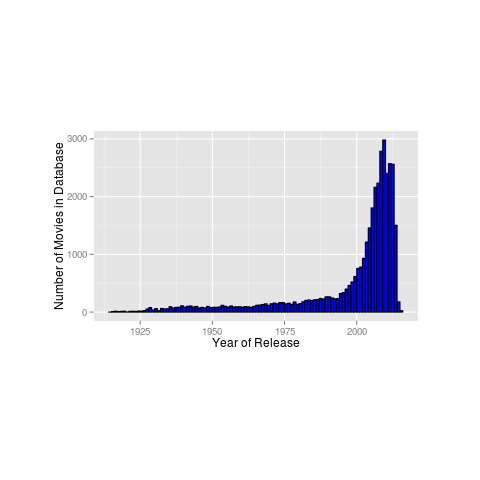

In [28]:
# pdf로 안만들고 바로 보기
ggplot.print.with.margins(ggplot.object.name = ggplot.object,
  left.margin.pct=10, right.margin.pct=10,
  top.margin.pct=10,bottom.margin.pct=10)

In [29]:
# let us work with movies from 1974 to 2013
# creating an aggregate tagline_text collection for each year of interest
years.list <- 1974:2013
document.collection <- NULL  # initialize
for (index.for.year in seq(along=years.list)) {
 
  working.year.data.frame = 
    subset(movies, subset = (year == years.list[index.for.year]))

  tagline_text <- NULL
  for(index.for.movie in seq(along = working.year.data.frame$movie)) 
    tagline_text <- 
      paste(tagline_text, working.year.data.frame$tagline[index.for.movie])
   
  document <- PlainTextDocument(x = tagline_text, author = "Tom",
    description = paste("movie taglines for ",
    as.character(years.list[index.for.year]),sep = ""),
    id = paste("movies_",as.character(years.list[index.for.year]),sep=""), 
    heading = "taglines",
    origin = "IMDb", language = "en_US", 
    localmetadata = list(year = years.list[index.for.year])) 

# give each created document a unique name  
  if (years.list[index.for.year] == 1974) Y1974 <- document  
  if (years.list[index.for.year] == 1975) Y1975 <- document  
  if (years.list[index.for.year] == 1976) Y1976 <- document  
  if (years.list[index.for.year] == 1977) Y1977 <- document  
  if (years.list[index.for.year] == 1978) Y1978 <- document  
  if (years.list[index.for.year] == 1979) Y1979 <- document     
  if (years.list[index.for.year] == 1980) Y1980 <- document  
  if (years.list[index.for.year] == 1981) Y1981 <- document   
  if (years.list[index.for.year] == 1982) Y1982 <- document  
  if (years.list[index.for.year] == 1983) Y1983 <- document  
  if (years.list[index.for.year] == 1984) Y1984 <- document  
  if (years.list[index.for.year] == 1985) Y1985 <- document  
  if (years.list[index.for.year] == 1986) Y1986 <- document  
  if (years.list[index.for.year] == 1987) Y1987 <- document  
  if (years.list[index.for.year] == 1988) Y1988 <- document  
  if (years.list[index.for.year] == 1989) Y1989 <- document  
  if (years.list[index.for.year] == 1990) Y1990 <- document  
  if (years.list[index.for.year] == 1991) Y1991 <- document   
  if (years.list[index.for.year] == 1992) Y1992 <- document  
  if (years.list[index.for.year] == 1993) Y1993 <- document  
  if (years.list[index.for.year] == 1994) Y1994 <- document  
  if (years.list[index.for.year] == 1995) Y1995 <- document  
  if (years.list[index.for.year] == 1996) Y1996 <- document  
  if (years.list[index.for.year] == 1997) Y1997 <- document  
  if (years.list[index.for.year] == 1998) Y1998 <- document  
  if (years.list[index.for.year] == 1999) Y1999 <- document  
  if (years.list[index.for.year] == 2000) Y2000 <- document  
  if (years.list[index.for.year] == 2001) Y2001 <- document   
  if (years.list[index.for.year] == 2002) Y2002 <- document  
  if (years.list[index.for.year] == 2003) Y2003 <- document  
  if (years.list[index.for.year] == 2004) Y2004 <- document  
  if (years.list[index.for.year] == 2005) Y2005 <- document  
  if (years.list[index.for.year] == 2006) Y2006 <- document  
  if (years.list[index.for.year] == 2007) Y2007 <- document  
  if (years.list[index.for.year] == 2008) Y2008 <- document  
  if (years.list[index.for.year] == 2009) Y2009 <- document  
  if (years.list[index.for.year] == 2010) Y2010 <- document  
  if (years.list[index.for.year] == 2011) Y2011 <- document  
  if (years.list[index.for.year] == 2012) Y2012 <- document  
  if (years.list[index.for.year] == 2013) Y2013 <- document  
  } # end of for-loop for selected years

In [30]:
document.collection <- c(Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,
  Y1980,Y1981,Y1982,Y1983,Y1984,Y1985,Y1986,Y1987,Y1988,Y1989,
  Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,
  Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,
  Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013)

In [31]:
# strip whitspace from the documents in the collection
# 원 저자 코드의 tm 버전과, 현재 이 노트북의 버전이 달라서 코드를 수정해 줌.
# 저저의 다른 책에 변경된 코드가 나와 있음 - https://books.google.co.kr/books?id=PU6nBAAAQBAJ&pg=PT145&lpg=PT145
# 소스 변경 관련 자료들
# http://stackoverflow.com/questions/24771165/r-project-no-applicable-method-for-meta-applied-to-an-object-of-class-charact
# http://stackoverflow.com/questions/21790353/dictionary-is-not-supported-anymore-in-tm-package-how-to-emend-code
document.collection <- tm_map(document.collection, stripWhitespace)

In [32]:
# convert uppercase to lowercase in the document collection
document.collection <- tm_map(document.collection, content_transformer(tolower))

In [33]:
# remove numbers from the document collection
document.collection <- tm_map(document.collection, removeNumbers)

In [34]:
# remove punctuation from the document collection
document.collection <- tm_map(document.collection, removePunctuation)

In [35]:
# using a standard list, remove English stopwords from the document collection
document.collection <- tm_map(document.collection, 
  removeWords, stopwords("english"))

In [36]:
# there is more we could do in terms of data preparation 
# stemming... looking for contractions... pronoun possessives... 

# we take what is clearly a "bag of words" approach here
# the workhorse technique will be TermDocumentMatrix()
# for creating a terms-by-documents matrix across the document collection
initial.movies.tdm <- TermDocumentMatrix(document.collection)

In [38]:
# remove sparse terms from the matrix and report the most common terms
# looking for additional stop words and stop word contractions to drop
examine.movies.tdm <- removeSparseTerms(initial.movies.tdm, sparse = 0.25)
top.words <- Terms(examine.movies.tdm)
print(top.words)  

  [1] "action"     "adventure"  "alive"      "alone"      "always"    
  [6] "america"    "american"   "americas"   "another"    "anything"  
 [11] "away"       "back"       "bad"        "battle"     "beautiful" 
 [16] "became"     "become"     "begins"     "behind"     "best"      
 [21] "beyond"     "big"        "biggest"    "black"      "blood"     
 [26] "body"       "born"       "boy"        "boys"       "business"  
 [31] "call"       "came"       "can"        "cant"       "century"   
 [36] "challenge"  "chance"     "city"       "classic"    "come"      
 [41] "comedy"     "comes"      "coming"     "cop"        "cops"      
 [46] "crime"      "dangerous"  "dark"       "day"        "days"      
 [51] "dead"       "deadly"     "death"      "deep"       "desire"    
 [56] "destroy"    "didnt"      "die"        "different"  "director"  
 [61] "doesnt"     "dont"       "dream"      "dreams"     "earth"     
 [66] "easy"       "end"        "enemy"      "enough"     "even"      
 [71] 

In [37]:
# an analysis of this initial list of top terms shows a number of word 
# contractions which we might like to drop from further analysis, 
# recognizing them as stop words to be dropped from the document collection
more.stop.words <- c("cant","didnt","doesnt","dont","goes","isnt","hes",
  "shes","thats","theres","theyre","wont","youll","youre","youve") 
document.collection <- tm_map(document.collection, 
  removeWords, more.stop.words)

In [38]:
# create terms-by-documents matrix across the final document collection
movies.tdm <- TermDocumentMatrix(document.collection)

In [39]:
# save movie documents and document collection (corpus)
save("movies","document.collection","movies.tdm",
  file = "09_data/text/000_movies_data.Rdata")  

In [40]:
# remove sparse terms from the matrix and report the most common terms
examine.movies.tdm <- removeSparseTerms(movies.tdm, sparse = 0.25)
top.words <- Terms(examine.movies.tdm)
print(top.words)  # the result of this is a bag of 200 words

  [1] "action"     "adventure"  "alive"      "alone"      "always"    
  [6] "america"    "american"   "americas"   "another"    "anything"  
 [11] "away"       "back"       "bad"        "battle"     "beautiful" 
 [16] "became"     "become"     "begins"     "behind"     "best"      
 [21] "beyond"     "big"        "biggest"    "black"      "blood"     
 [26] "body"       "born"       "boy"        "boys"       "business"  
 [31] "call"       "came"       "can"        "century"    "challenge" 
 [36] "chance"     "city"       "classic"    "come"       "comedy"    
 [41] "comes"      "coming"     "cop"        "cops"       "crime"     
 [46] "dangerous"  "dark"       "day"        "days"       "dead"      
 [51] "deadly"     "death"      "deep"       "desire"     "destroy"   
 [56] "die"        "different"  "director"   "dream"      "dreams"    
 [61] "earth"      "easy"       "end"        "enemy"      "enough"    
 [66] "even"       "ever"       "every"      "everyone"   "everything"
 [71] 

In [41]:
# now comes a test... 
# does looking at taglines hold promise as a way of identifying movie trends?
# if it does, then years closest in time should be closest to one
# another in a text measurement space as reflected, say, 
# by multidimensional scaling... 
# create a dictionary of the top words from the corpus
#top.words.dictionary <- Dictionary(c(top.words))
top.words.dictionary <- c(as.character(top.words))

In [42]:
# create terms-by-documents matrix using the mtpa.Dictionary
top.words.movies.tdm <- TermDocumentMatrix(document.collection, 
  list(dictionary = top.words.dictionary))

In [43]:
# dissimilarity measures and multidimensional scaling
# with wordlayout from the wordcloud package for non-overlapping labels
pdf(file = "09_data/text/fig_text_mds_1974_2013.pdf", width = 7, height = 7)
years.dissimilarity.matrix <- 
  dist(t(inspect(top.words.movies.tdm)), method = "cosine")
years.mds.solution <- cmdscale(years.dissimilarity.matrix, k = 2, eig = TRUE)
x <- years.mds.solution$points[,1]
y <- -years.mds.solution$points[,2]  # rotated to be consistent with biplot
w <- c("1974","1975","1976","1977","1978","1979",
  "1980","1981","1982","1983","1984","1985","1986",
  "1987","1988","1989","1990","1991","1992","1993",
  "1994","1995","1996","1997","1998","1999","2000",
  "2001","2002","2003","2004","2005","2006","2007",
  "2008","2009","2010","2011","2012","2013")
plot(x,y,type="n", xlim = c(-0.075,0.075), ylim = c(-0.075,0.075),
  xlab = "First Dimension", ylab = "Second Dimension") 
lay <- wordlayout(x, y, w, xlim = c(-0.075,0.075), ylim = c(-0.075,0.075)) 
text(lay[,1]+.5*lay[,3],lay[,2]+.5*lay[,4],w)
dev.off()

<<TermDocumentMatrix (terms: 284, documents: 40)>>
Non-/sparse entries: 10099/1261
Sparsity           : 11%
Maximal term length: 10
Weighting          : term frequency (tf)

            Docs
Terms        movies_1974 movies_1975 movies_1976 movies_1977 movies_1978
  action               5           6           5           6           4
  adventure            2           2           4           2           9
  alive                2           2           2           1           5
  alone                1           1           0           0           0
  always               2           4           3           1           2
  america              0           1           3           2           0
  american             4           1           1           3           0
  americas             3           0           0           2           2
  another              1           0           0           0           2
  anything             3           2           1           1           0
  away

pdf 
  2 

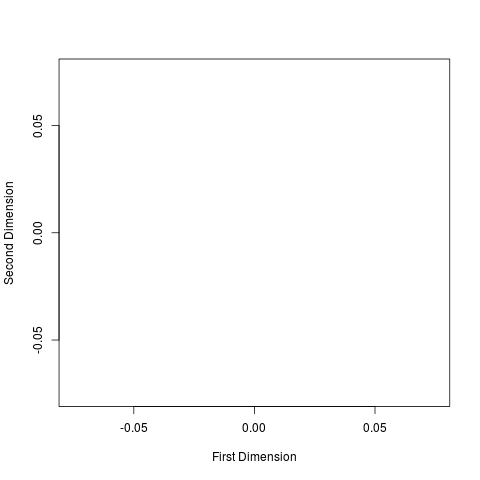

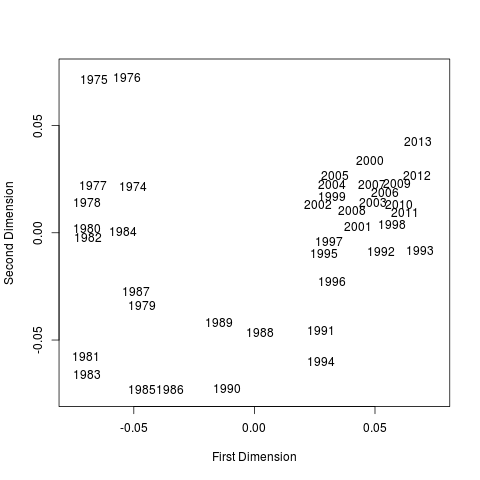

In [44]:
plot(x,y,type="n", xlim = c(-0.075,0.075), ylim = c(-0.075,0.075),
  xlab = "First Dimension", ylab = "Second Dimension") 
lay <- wordlayout(x, y, w, xlim = c(-0.075,0.075), ylim = c(-0.075,0.075)) 
text(lay[,1]+.5*lay[,3],lay[,2]+.5*lay[,4],w)

In [45]:
# classification of words into groups for further analysis
# use transpose of the terms-by-document matrix and cluster analysis
words.distance.object <- 
  dist(x = as.matrix(top.words.movies.tdm), method = "euclidean")

In [46]:
pdf(file = "09_data/text/fig_text_hcluster_top_words.pdf", width = 11, height = 8.5)
top.words.hierarchical.clustering <- 
  agnes(words.distance.object,diss=TRUE,
    metric = "euclidean", stand = FALSE, method = "ward") 
plot(top.words.hierarchical.clustering, cex.lab = 0.05)
dev.off()

pdf 
  2 

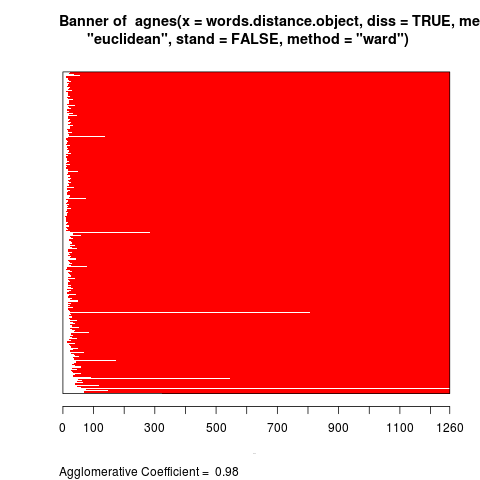

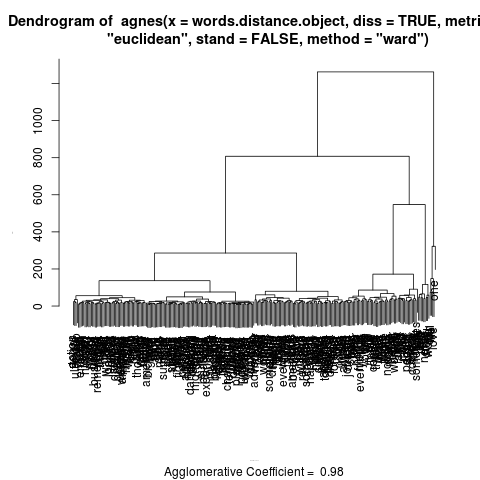

In [47]:
plot(top.words.hierarchical.clustering, cex.lab = 0.05)

In [48]:
# hierarchical solution suggests that four or five clusters may work
# examine possible clustering soltions with partitioning
number.of.clusters.test <- NULL
for(number.of.clusters in 2:20) {
  try.words.clustering <- pam(words.distance.object,diss=TRUE,
    metric = "euclidean", stand = FALSE, k = number.of.clusters) 
  number.of.clusters.test <- 
    rbind(number.of.clusters.test,
      data.frame(number.of.clusters, 
        ave.sil.width = try.words.clustering$silinfo$avg.width)) 
   cat("\n\n","Number of clusters: ",number.of.clusters,
     " Average silhouette width: ",try.words.clustering$silinfo$avg.width,
     "\nKey identified concepts: ",try.words.clustering$medoids,
     "\nCluster average silhouette widths: ")
   print(try.words.clustering$silinfo$clus.avg.widths)
  }  # end of for-loop for number-of-clusters test 
print(number.of.clusters.test)



 Number of clusters:  2  Average silhouette width:  0.4773396 
Key identified concepts:  business truth 
Cluster average silhouette widths: [1]  0.71241630 -0.06388336


 Number of clusters:  3  Average silhouette width:  0.435928 
Key identified concepts:  business thing never 
Cluster average silhouette widths: [1] 0.5432990 0.2577792 0.2235283


 Number of clusters:  4  Average silhouette width:  0.28865 
Key identified concepts:  head dark truth world 
Cluster average silhouette widths: [1] 0.3968409 0.2117229 0.1985361 0.2137044


 Number of clusters:  5  Average silhouette width:  0.2990162 
Key identified concepts:  head dark truth life never 
Cluster average silhouette widths: [1] 0.3968409 0.2117229 0.1949486 0.2297078 0.5550443


 Number of clusters:  6  Average silhouette width:  0.2394509 
Key identified concepts:  anything head thing everything life never 
Cluster average silhouette widths: [1] 0.1455205 0.3773304 0.1523494 0.1665684 0.2297078 0.5070987


 Number of clus

In [49]:
# results suggest that five clusters may work best here 
# we examine these clusters and give them names corresponding to medoids
top.words.clustering <- pam(words.distance.object,diss=TRUE,
    metric = "euclidean", stand = FALSE, k = 5)

In [50]:
# review the clustering results
print(summary(top.words.clustering))

Medoids:
     ID           
[1,] "112" "head" 
[2,] "47"  "dark" 
[3,] "256" "truth"
[4,] "144" "life" 
[5,] "179" "never"
Clustering vector:
    action  adventure      alive      alone     always    america   american 
         1          2          1          1          3          1          2 
  americas    another   anything       away       back        bad     battle 
         1          2          2          2          3          2          2 
 beautiful     became     become     begins     behind       best     beyond 
         1          1          2          2          2          3          1 
       big    biggest      black      blood       body       born        boy 
         3          1          1          1          1          1          2 
      boys   business       call       came        can    century  challenge 
         1          1          1          1          4          1          1 
    chance       city    classic       come     comedy      comes     coming 


In [51]:
# the medoid identified through the clustering process
# is an object at the center of the cluster... 
# it is used to define the cluster here we identify their names
cat("\nKey Words Identified by Cluster Analysis: \n")
key.word.set <- top.words.clustering$medoids
print(key.word.set)


Key Words Identified by Cluster Analysis: 
[1] "head"  "dark"  "truth" "life"  "never"


In [52]:
# convert the distance object to an actual distance matrix 
# for doing word searches directly on the matrix calculations
words.distance.matrix <- as.matrix(words.distance.object)

In [53]:
# for each medoid... identify the closest words from distance matrix
# let us choose the two closest words to have five lists of three words
# for further analysis... note that there is some overlap in word sets
for(index.for.key.word in seq(along=key.word.set)) {
  # identify the column for the key word
  key.word.column <- 
    words.distance.matrix[,c(key.word.set[index.for.key.word])]
  # sort the key word column by distance
  sorted.key.word.column <- sort(key.word.column)
  # the smallest distance will be the distance of the key word to itself
  # so choose the second through tenth words in from the sorted column
  print(sorted.key.word.column[1:5])
  if (index.for.key.word == 1) 
    loved.word.set <- names(sorted.key.word.column[1:3])
  if (index.for.key.word == 2) 
    worlds.word.set <- names(sorted.key.word.column[1:3])
  if (index.for.key.word == 3) 
    truth.word.set <- names(sorted.key.word.column[1:3])
  if (index.for.key.word == 4) 
    life.word.set <- names(sorted.key.word.column[1:3])
  if (index.for.key.word == 5) 
    story.word.set <- names(sorted.key.word.column[1:3])
  }

     head     loved      boys     stand  fighting 
 0.000000  9.165151  9.327379 10.198039 10.583005 
    dark     mans      old  another   become 
 0.00000 15.90597 15.93738 16.76305 17.20465 
   truth    dream     show  journey   things 
 0.00000 20.56696 23.00000 23.25941 23.85372 
     life      love       can      will     world 
  0.00000  68.05145  84.64042 115.57681 171.92149 
   never     just     time      get    story 
 0.00000 40.43513 44.56456 52.56425 54.80876 


In [54]:
# turn the word sets into dictionaries for analysis 
loved.words.dictionary <- c(as.character(loved.word.set))
worlds.words.dictionary <- c(as.character(worlds.word.set))
truth.words.dictionary <- c(as.character(truth.word.set))
life.words.dictionary <- c(as.character(life.word.set))
story.words.dictionary <- c(as.character(story.word.set))

In [55]:
# do word counts across the dictionaries
year <- 1974:2013
total.words <- integer(length(year))
loved.words <- integer(length(year))
worlds.words <- integer(length(year))
truth.words <- integer(length(year))
life.words <- integer(length(year))
story.words <- integer(length(year))

In [56]:
for(index.for.document in seq(along=year)) {
  loved.words[index.for.document] <- 
    sum(termFreq(document.collection[[index.for.document]], 
    control = list(dictionary = loved.words.dictionary)))
    
  worlds.words[index.for.document] <- 
    sum(termFreq(document.collection[[index.for.document]], 
    control = list(dictionary = worlds.words.dictionary)))  
    
  truth.words[index.for.document] <- 
    sum(termFreq(document.collection[[index.for.document]], 
    control = list(dictionary = truth.words.dictionary))) 
    
  life.words[index.for.document] <- 
    sum(termFreq(document.collection[[index.for.document]], 
    control = list(dictionary = life.words.dictionary)))     
    
  story.words[index.for.document] <- 
    sum(termFreq(document.collection[[index.for.document]], 
    control = list(dictionary = story.words.dictionary)))     
    
  total.words[index.for.document] <- 
    length(movies.tdm[,index.for.document][["i"]])
  }

In [57]:
# gather the results up in a data frame
movie.analytics.data.frame <- data.frame(year, total.words,
  loved.words, worlds.words, truth.words, life.words, story.words) 

In [58]:
# compute text measures as percentages of words in each set

movie.analytics.data.frame$LOVED <- 
  100 * movie.analytics.data.frame$loved.words / 
    movie.analytics.data.frame$total.words
LOVED <- standardize(movie.analytics.data.frame$LOVED)    
LOVED.ts <- ts(LOVED, start = c(1974,1), end = c(2013,1), frequency = 1)

In [59]:
movie.analytics.data.frame$WORLDS <- 
  100 * movie.analytics.data.frame$worlds.words / 
    movie.analytics.data.frame$total.words
WORLDS <- standardize(movie.analytics.data.frame$WORLDS)    
WORLDS.ts <- ts(WORLDS, start = c(1974,1), end = c(2013,1), frequency = 1)

In [60]:
movie.analytics.data.frame$TRUTH <- 
  100 * movie.analytics.data.frame$truth.words / 
    movie.analytics.data.frame$total.words
TRUTH <- standardize(movie.analytics.data.frame$TRUTH)    
TRUTH.ts <- ts(TRUTH, start = c(1974,1), end = c(2013,1), frequency = 1)

In [61]:
movie.analytics.data.frame$LIFE <- 
  100 * movie.analytics.data.frame$life.words / 
    movie.analytics.data.frame$total.words
LIFE <- standardize(movie.analytics.data.frame$LIFE)    
LIFE.ts <- ts(LIFE, start = c(1974,1), end = c(2013,1), frequency = 1)

In [62]:
movie.analytics.data.frame$STORY <- 
  100 * movie.analytics.data.frame$story.words / 
    movie.analytics.data.frame$total.words
STORY <- standardize(movie.analytics.data.frame$STORY)    
STORY.ts <- ts(STORY, start = c(1974,1), end = c(2013,1), frequency = 1)

In [63]:
# data frame of standardized text measures
text.measures.data.frame <- data.frame(LOVED,WORLDS,TRUTH,LIFE,STORY)
rownames(text.measures.data.frame) <- 1974:2013

In [64]:
principal.components.solution <- princomp(text.measures.data.frame, cor = TRUE)
print(summary(principal.components.solution))  

Importance of components:
                         Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     1.872027 0.9828302 0.52411411 0.38859438 0.32227059
Proportion of Variance 0.700897 0.1931910 0.05493912 0.03020112 0.02077167
Cumulative Proportion  0.700897 0.8940881 0.94902721 0.97922833 1.00000000


In [65]:
# biplot rendering of text measures and documents by year
pdf(file = "09_data/text/fig_text_text_measures_biplot.pdf", width = 8.5, height = 11)
biplot(principal.components.solution, xlab = "First Pricipal Component",
  ylab = "Second Principal Component", col = c("black","darkblue"), las = 1)
dev.off()

pdf 
  2 

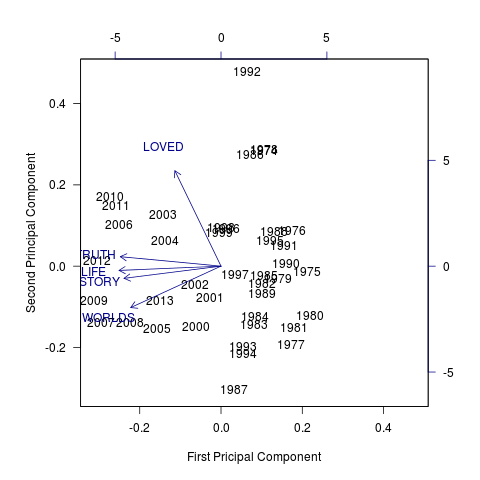

In [66]:
biplot(principal.components.solution, xlab = "First Pricipal Component",
  ylab = "Second Principal Component", col = c("black","darkblue"), las = 1)

In [67]:
# multiple time series object for text measures
text.measures.mts <- cbind(LOVED.ts, WORLDS.ts, TRUTH.ts, LIFE.ts, STORY.ts)
colnames(text.measures.mts) <- c("LOVED","WORLDS","TRUTH","LIFE","STORY")

In [68]:
# text horizons for forty years of movies
pdf(file = "09_data/text/fig_text_horizon_1974_2013.pdf", width = 8.5, height = 11)
print(horizonplot(text.measures.mts, colorkey = TRUE,
  layout = c(1,5), strip.left = FALSE, horizonscale = 1,
  origin = 0,
  ylab = list(rev(colnames(text.measures.mts)), rot = 0, cex = 0.7)) +
  layer_(panel.fill(col = "gray90"), panel.xblocks(..., col = "white")))
dev.off()

pdf 
  2 

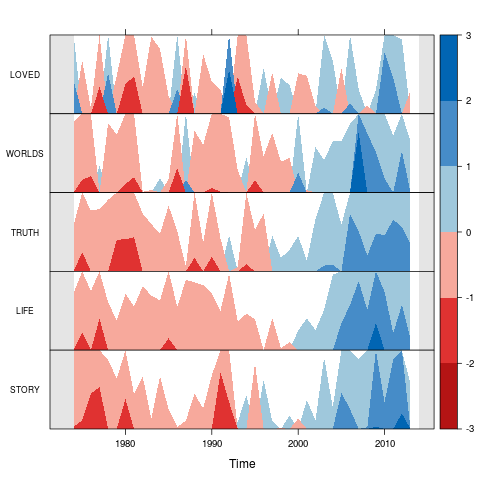

In [69]:
print(horizonplot(text.measures.mts, colorkey = TRUE,
  layout = c(1,5), strip.left = FALSE, horizonscale = 1,
  origin = 0,
  ylab = list(rev(colnames(text.measures.mts)), rot = 0, cex = 0.7)) +
  layer_(panel.fill(col = "gray90"), panel.xblocks(..., col = "white")))

In [70]:
# wordcloud for all R program code up to this point in the book
R.code.text <- scan("09_data/text/MTPA_R_code.txt", what = "char", sep = "\n")

In [71]:
# replace uppercase with lowercase letters
R.code.text <- tolower(R.code.text)

In [72]:
# strip out all non-letters and return vector
R.code.text.preword.vector <- unlist(strsplit(R.code.text, "\\W"))

In [73]:
# drop all empty words 
R.code.text.vector <- 
  R.code.text.preword.vector[which(nchar(R.code.text.preword.vector) > 0)]

In [74]:
pdf(file = "09_data/text/fig_text_wordcloud_of_R_code.pdf", width = 11, height = 8.5)
set.seed(1234) 
wordcloud(R.code.text.vector,   min.freq = 10,
  max.words = 300,
  random.order=FALSE,
  random.color=FALSE,
  rot.per=0.0,
  colors="black",
  ordered.colors=FALSE, 
  use.r.layout=FALSE,
  fixed.asp=TRUE)
dev.off()

pdf 
  2 

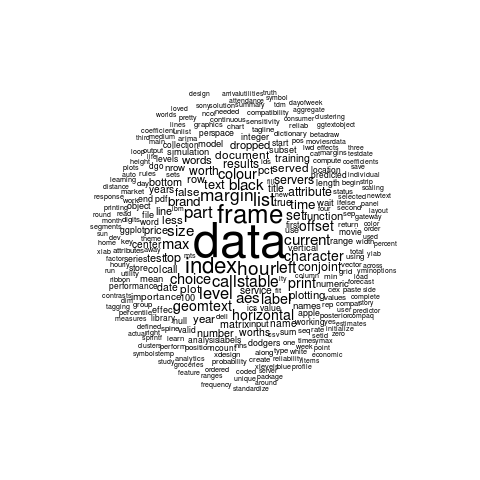

In [75]:
wordcloud(R.code.text.vector,   min.freq = 10,
  max.words = 300,
  random.order=FALSE,
  random.color=FALSE,
  rot.per=0.0,
  colors="black",
  ordered.colors=FALSE, 
  use.r.layout=FALSE,
  fixed.asp=TRUE)

In [26]:
# Split-Plotting Utilities with grid Graphics

library(grid)  # grid graphics foundation of split-plotting utilities

# functions used with ggplot2 graphics to split the plotting region
# to set margins and to plot more than one ggplot object on one page/screen
vplayout <- function(x, y) 
viewport(layout.pos.row=x, layout.pos.col=y) 

# grid graphics utility plots one plot with margins
ggplot.print.with.margins <- function(ggplot.object.name,left.margin.pct=10,
  right.margin.pct=10,top.margin.pct=10,bottom.margin.pct=10)
{ # begin function for printing ggplot objects with margins
  # margins expressed as percentages of total... use integers
 grid.newpage() 
pushViewport(viewport(layout=grid.layout(100,100)))
print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):(100 - bottom.margin.pct),
  (0 + left.margin.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins

# grid graphics utility plots two ggplot plotting objects in one column
special.top.bottom.ggplot.print.with.margins <- 
  function(ggplot.object.name,ggplot.text.tagging.object.name,
  left.margin.pct=5,right.margin.pct=5,top.margin.pct=5,
  bottom.margin.pct=5,plot.pct=80,text.tagging.pct=10) { 
# begin function for printing ggplot objects with margins 
# and text tagging at bottom of plot
# margins expressed as percentages of total... use integers
  if((top.margin.pct + bottom.margin.pct + plot.pct + text.tagging.pct) != 100) 
    stop(paste("function special.top.bottom.ggplot.print.with.margins()",
    "execution terminated:\n   top.margin.pct + bottom.margin.pct + ",
    "plot.pct + text.tagging.pct not equal to 100 percent",sep=""))  
  grid.newpage() 
  pushViewport(viewport(layout=grid.layout(100,100)))
  print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):
    (100 - (bottom.margin.pct + text.tagging.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

  print(ggplot.text.tagging.object.name, 
    vp=vplayout((0 + (top.margin.pct + plot.pct)):(100 - bottom.margin.pct),
    (0 + left.margin.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins and text tagging

# grid graphics utility plots three ggplot plotting objects in one column
three.part.ggplot.print.with.margins <- function(ggfirstplot.object.name,
ggsecondplot.object.name,
ggthirdplot.object.name,
left.margin.pct=5,right.margin.pct=5,
top.margin.pct=10,bottom.margin.pct=10,
first.plot.pct=25,second.plot.pct=25,
third.plot.pct=30) { 
# function for printing ggplot objects with margins and top and bottom plots
# margins expressed as percentages of total... use integers
if((top.margin.pct + bottom.margin.pct + first.plot.pct + 
  second.plot.pct  + third.plot.pct) != 100) 
    stop(paste("function special.top.bottom.ggplot.print.with.margins()",
         "execution terminated:\n   top.margin.pct + bottom.margin.pct",
         "+ first.plot.pct + second.plot.pct  + third.plot.pct not equal",
         "to 100 percent",sep=""))  
grid.newpage() 
pushViewport(viewport(layout=grid.layout(100,100)))

print(ggfirstplot.object.name, vp=vplayout((0 + top.margin.pct):
  (100 - (second.plot.pct  + third.plot.pct + bottom.margin.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

print(ggsecondplot.object.name, 
  vp=vplayout((0 + top.margin.pct + first.plot.pct):
  (100 - (third.plot.pct + bottom.margin.pct)),
  (0 + left.margin.pct):(100 - right.margin.pct))) 

print(ggthirdplot.object.name, 
  vp=vplayout((0 + top.margin.pct + first.plot.pct + second.plot.pct):
  (100 - (bottom.margin.pct)),(0 + left.margin.pct):
  (100 - right.margin.pct))) 
} 

# grid graphics utility plots two ggplot plotting objects in one row
# primary plot graph at left... legend at right
special.left.right.ggplot.print.with.margins <- 
  function(ggplot.object.name, ggplot.text.legend.object.name,
  left.margin.pct=5, right.margin.pct=5, top.margin.pct=5,
  bottom.margin.pct=5, plot.pct=85, text.legend.pct=5) { 
# begin function for printing ggplot objects with margins 
# and text legend at bottom of plot
# margins expressed as percentages of total... use integers
  if((left.margin.pct + right.margin.pct + plot.pct + text.legend.pct) != 100) 
    stop(paste("function special.left.right.ggplot.print.with.margins()",
    "execution terminated:\n   left.margin.pct + right.margin.pct + ",
    "plot.pct + text.legend.pct not equal to 100 percent",sep=""))  
  grid.newpage() 
  pushViewport(viewport(layout=grid.layout(100,100)))
  print(ggplot.object.name, 
  vp=vplayout((0 + top.margin.pct):(100 - (bottom.margin.pct)),
  (0 + left.margin.pct + text.legend.pct):(100 - right.margin.pct))) 

  print(ggplot.text.legend.object.name, 
    vp=vplayout((0 + (top.margin.pct)):(100 - bottom.margin.pct),
    (0 + left.margin.pct + plot.pct):(100 - right.margin.pct))) 
} # end function for printing ggplot objects with margins and text legend

# 참고자료